In [1]:
# import numpy, tensorflow and matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

# import VGG 19 model and keras Model API
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model


In [2]:
# Image Credits: Tensorflow Doc
content_path = tf.keras.utils.get_file(
'content.jpg',
'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file(
'style.jpg',
'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


195196/195196 [==============================] - 0s 1us/step


In [3]:
# code to load and process image
def load_and_process_image(image_path):
	img = load_img(image_path)
	# convert image to array
	img = img_to_array(img)
	img = preprocess_input(img)
	img = np.expand_dims(img, axis=0)
	return img


In [4]:
# code
def deprocess(img):
	# perform the inverse of the pre processing step
	img[:, :, 0] += 103.939
	img[:, :, 1] += 116.779
	img[:, :, 2] += 123.68
	# convert RGB to BGR
	img = img[:, :, ::-1]

	img = np.clip(img, 0, 255).astype('uint8')
	return img


def display_image(image):
	# remove one dimension if image has 4 dimension
	if len(image.shape) == 4:
		img = np.squeeze(image, axis=0)

	img = deprocess(img)

	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	plt.imshow(img)
	return


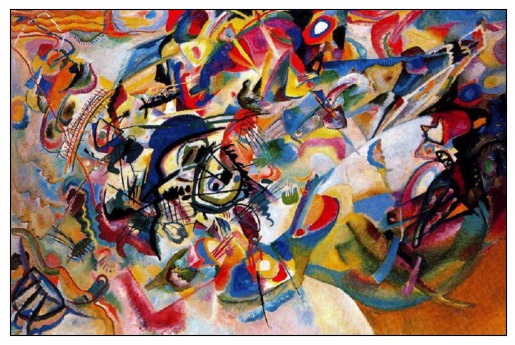

In [5]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)

# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)


In [6]:
# code
# this function download the VGG model and initialise it
model = VGG19(
	include_top=False,
	weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers

model.summary()


80134624/80134624 [==============================] - 33s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                             

In [7]:
# define content model
content_layer = 'block5_conv2'
content_model = Model(
	inputs=model.input,
	outputs=model.get_layer(content_layer).output
)
content_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [8]:
# define style model
style_layers = [
	'block1_conv1',
	'block3_conv1',
	'block5_conv1'
]
style_models = [Model(inputs=model.input,
					outputs=model.get_layer(layer).output) for layer in style_layers]


In [9]:
# Content loss
def content_loss(content, generated):
	a_C = content_model(content)
	a_G = content_model(generated) # Add this line to compute a_G
	loss = tf.reduce_mean(tf.square(a_C - a_G))
	return loss


In [10]:
# gram matrix
def gram_matrix(A):
	channels = int(A.shape[-1])
	a = tf.reshape(A, [-1, channels])
	n = tf.shape(a)[0]
	gram = tf.matmul(a, a, transpose_a=True)
	return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)


In [11]:
#style loss
def style_cost(style, generated):
	J_style = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_style += content_cost * weight_of_layer

	return J_style


In [12]:
#content loss
def content_cost(style, generated):
	J_content = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_content += content_cost * weight_of_layer

	return J_content


In [15]:
# training function
generated_images = []


def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
	# load content and style images from their respective path
	content = load_and_process_image(content_path)
	style = load_and_process_image(style_path)
	generated = tf.Variable(content, dtype=tf.float32)

	opt = tf.keras.optimizers.Adam(learning_rate=7)

	best_cost = math.inf
	best_image = None
	for i in range(iterations):
		start_time_cpu = time.process_time()
		start_time_wall = time.time()
		with tf.GradientTape() as tape:
			J_content = content_cost(style, generated)
			J_style = style_cost(style, generated)
			J_total = a * J_content + b * J_style

		grads = tape.gradient(J_total, generated)
		opt.apply_gradients([(grads, generated)])

		end_time_cpu = time.process_time() # Record end time for CPU
		end_time_wall = time.time() # Record end time for wall time
		cpu_time = end_time_cpu - start_time_cpu # Calculate CPU time
		wall_time = end_time_wall - start_time_wall # Calculate wall time

		if J_total < best_cost:
			best_cost = J_total
			best_image = generated.numpy()

		print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
		int(cpu_time * 1e6),
		int(( end_time_cpu - start_time_cpu) * 1e9),
		int((end_time_cpu - start_time_cpu + 1e-6) * 1e6))
			)
		
		print("Wall time: {:.2f} µs".format(wall_time * 1e6))
		print("Iteration :{}".format(i))
		print('Total Loss {:e}.'.format(J_total))
		generated_images.append(generated.numpy())

	return best_image


In [21]:
import tensorflow as tf
import numpy as np
import time
import math

# Dummy implementations for missing functions
def load_and_process_image(path):
    # Replace with actual image loading and processing
    return np.random.rand(256, 256, 3).astype(np.float32)

def content_cost(style, generated):
    # Replace with actual content cost computation
    return tf.reduce_sum((generated - style) ** 2)

def style_cost(style, generated):
    # Replace with actual style cost computation
    return tf.reduce_sum((generated - style) ** 2)

# Training loop function
generated_images = []

def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
    # Load content and style images
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)

    opt = tf.keras.optimizers.Adam(learning_rate=7)

    best_cost = math.inf
    best_image = None
    for i in range(iterations):
        start_time_cpu = time.process_time()
        start_time_wall = time.time()
        with tf.GradientTape() as tape:
            J_content = content_cost(style, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style

        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])

        end_time_cpu = time.process_time()
        end_time_wall = time.time()
        cpu_time = end_time_cpu - start_time_cpu
        wall_time = end_time_wall - start_time_wall

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
            int(cpu_time * 1e6),
            int((end_time_cpu - start_time_cpu) * 1e9),
            int((end_time_cpu - start_time_cpu + 1e-6) * 1e6))
        )
        
        print("Wall time: {:.2f} µs".format(wall_time * 1e6))
        print("Iteration :{}".format(i))
        print('Total Loss {:e}.'.format(J_total))
        generated_images.append(generated.numpy())

    return best_image

# Train the model and get the best image
final_img = training_loop(content_path, style_path)


CPU times: user 31250 µs, sys: 31250000 ns, total: 31251 µs
Wall time: 75179.58 µs
Iteration :0
Total Loss 3.311832e+07.
CPU times: user 0 µs, sys: 0 ns, total: 1 µs
Wall time: 20929.10 µs
Iteration :1
Total Loss 8.836082e+09.
CPU times: user 31250 µs, sys: 31250000 ns, total: 31251 µs
Wall time: 18666.51 µs
Iteration :2
Total Loss 5.797486e+08.
CPU times: user 0 µs, sys: 0 ns, total: 1 µs
Wall time: 21084.31 µs
Iteration :3
Total Loss 1.927061e+09.
CPU times: user 0 µs, sys: 0 ns, total: 1 µs
Wall time: 17071.49 µs
Iteration :4
Total Loss 5.046011e+09.
CPU times: user 15625 µs, sys: 15625000 ns, total: 15626 µs
Wall time: 19956.35 µs
Iteration :5
Total Loss 3.637031e+09.
CPU times: user 15625 µs, sys: 15625000 ns, total: 15626 µs
Wall time: 18256.19 µs
Iteration :6
Total Loss 9.075222e+08.
CPU times: user 0 µs, sys: 0 ns, total: 1 µs
Wall time: 18482.21 µs
Iteration :7
Total Loss 5.096053e+07.
CPU times: user 15625 µs, sys: 15625000 ns, total: 15626 µs
Wall time: 18701.55 µs
Iteration

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image):
    # Convert image to a format suitable for displaying
    if image.ndim == 4:  # Check if the image has a batch dimension
        image = image[0]
    image = np.clip(image, 0, 1)  # Ensure pixel values are in [0, 1]
    plt.imshow(image)
    plt.axis('off')  # Hide axes


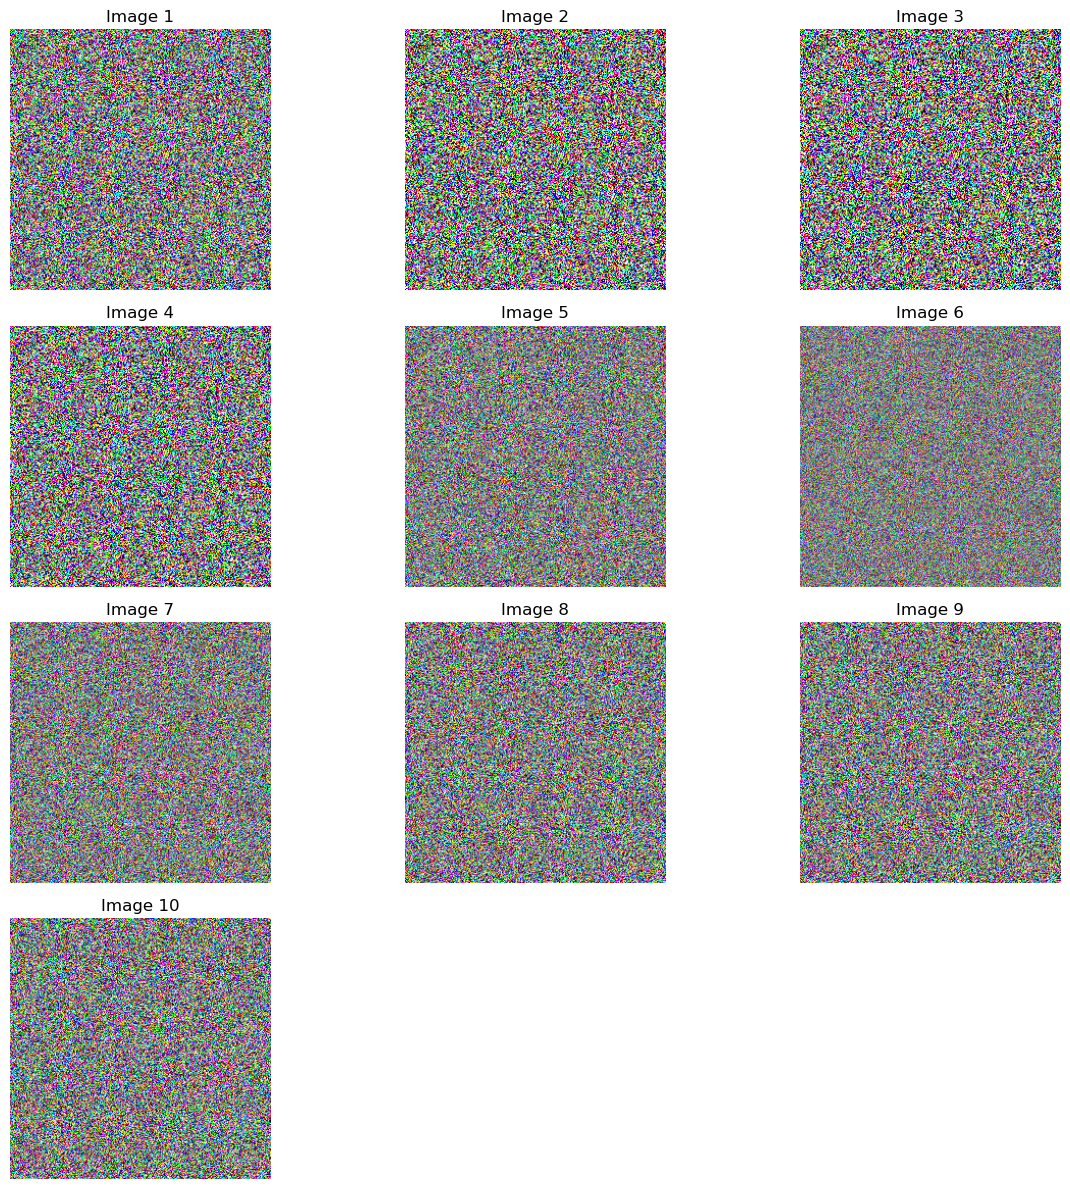

In [28]:
import matplotlib.pyplot as plt

def display_image(image, cmap=None):
    if image.ndim == 4:  # Check if the image has a batch dimension
        image = image[0]
    image = np.clip(image, 0, 1)  # Ensure pixel values are in [0, 1]
    plt.imshow(image, cmap=cmap)
    plt.axis('off')  # Hide axes

plt.figure(figsize=(12, 12))

num_images_to_show = min(10, len(generated_images))  # Handle cases where fewer than 10 images are available

for i in range(num_images_to_show):
    plt.subplot(4, 3, i + 1)
    cmap = None
    if i % 2 == 0:
        cmap = 'gray'  # Use grayscale for even images
    display_image(generated_images[-num_images_to_show + i], cmap=cmap)
    plt.title(f"Image {i + 1}")

plt.tight_layout()
plt.show()
